# 分割 dominator

In [1]:
from testing import viz_expr # 可视化 relay

In [2]:
import tvm
from tvm import relay
from tvm.relay.dataflow_pattern import *

构建计算图：

In [3]:
def generate_diamond(inp, weight):
    conv2d = relay.op.nn.conv2d(inp, weight)
    relu = relay.op.nn.relu(conv2d)
    relu = relay.op.nn.relu(relu)
    leaky_relu = relay.op.nn.leaky_relu(conv2d, alpha=0)
    return relu + leaky_relu

In [4]:
# Classic Diamond
inp = relay.var("input")
weight = relay.var("weight")
out = generate_diamond(inp * inp, weight * weight)

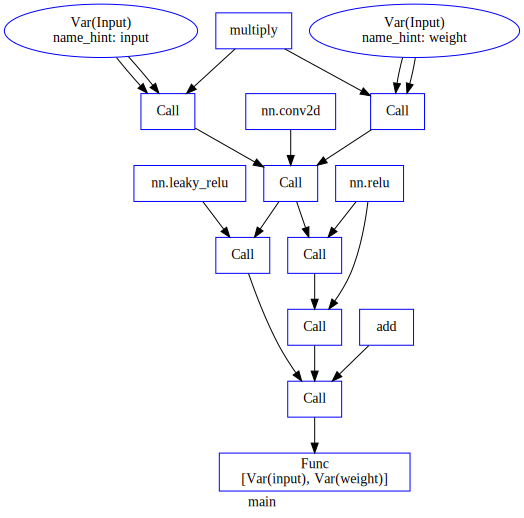

In [5]:
viz_expr(out)

In [8]:
print(tvm.IRModule.from_expr(out))

def @main(%input, %weight) {
  %0 = multiply(%input, %input);
  %1 = multiply(%weight, %weight);
  %2 = nn.conv2d(%0, %1, padding=[0, 0, 0, 0]);
  %3 = nn.relu(%2);
  %4 = nn.relu(%3);
  %5 = nn.leaky_relu(%2, alpha=0f);
  add(%4, %5)
}



构建模式：

In [7]:
# NB: 1 corresponds to the C++ enum that specicfies this
# we loose the type safety due to the Python/C++ calling
# convention.
K_ELEMWISE = 0
K_BROADCAST = 1

# Pattern
is_conv2d = is_op("nn.conv2d")(wildcard(), wildcard())
is_unary_elemwise = (wildcard().has_attr({"TOpPattern": K_ELEMWISE}))(wildcard())
reduction = is_op("add")(wildcard(), wildcard())
diamond = dominates(is_conv2d, is_unary_elemwise, reduction)

分割计算图：

In [9]:
partitioned = diamond.partition(out)

In [10]:
print(tvm.IRModule.from_expr(partitioned))

def @main(%input, %weight) {
  %4 = multiply(%input, %input);
  %5 = multiply(%weight, %weight);
  %6 = fn (%FunctionVar_0_0, %FunctionVar_0_1, PartitionedFromPattern="nn.conv2d_nn.relu_nn.relu_nn.leaky_relu_add_") {
    %0 = nn.conv2d(%FunctionVar_0_0, %FunctionVar_0_1, padding=[0, 0, 0, 0]);
    %1 = nn.relu(%0);
    %2 = nn.relu(%1);
    %3 = nn.leaky_relu(%0, alpha=0f);
    add(%2, %3)
  };
  %6(%4, %5)
}

